In [1]:
import pandas as pd
import datetime
import numpy as np
from tqdm import tqdm
from ipywidgets import IntProgress

# local file paths
input_file_path = f'../../../siads591 data/filtered_raw/gabbard_min.pkl.gz'
out_path = f'../../../siads591 data/processed_data/gabbard/'

# freq             frequency of datapoints after reindexing
# start_date       start date for data to start processing - remember to leave enough gap for interpolation
# interpolate_lim  limits of interpolation based on the frequency
#                  (1D frequency, 30 limit = 30 days 1 way, effectively a max of 60 days between points)
# out_file_name    output file name

freq, start_date, interpolate_lim, out_file_name = '36H', None, 20, 'gabbard_36H20.pkl'
# freq, start_date, interpolate_lim, out_file_name = '1D', '1979-10-01', 45, 'gabbard_1D_scaled_1980.pkl'
# freq, start_date, interpolate_lim, out_file_name = '1D', None, 30, 'gabbard_1D_scaled_il30.pkl'
# freq, start_date, interpolate_lim, out_file_name = '12H', '1979-10-01', 90, 'gabbard_scaled_1980.pkl'
# freq, start_date, interpolate_lim, out_file_name = '5D', None, 12, 'gabbard_5D_scaled.pkl'

In [2]:
raw_df = pd.read_pickle(f'{input_file_path}', compression="gzip")

In [3]:
if start_date != None:
    raw_df = raw_df[raw_df.index > start_date]

In [4]:
display(raw_df.head(4))
display(raw_df.info())

,NORAD_CAT_ID,PERIOD_x500,APOAPSIS_x20,PERIAPSIS_x20
EPOCH,,,,
2004-04-27 14:18:48.216960,18549,56019,37260,15554
2004-04-27 15:59:40.727904,18727,56952,29484,26739
2004-04-27 19:45:13.686048,19027,51961,20122,17635
2004-04-27 15:43:11.393472,19128,52496,22942,16822


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86436026 entries, 2004-04-27 14:18:48.216960 to 2021-02-01 22:42:31.311936
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   NORAD_CAT_ID   uint16
 1   PERIOD_x500    UInt16
 2   APOAPSIS_x20   UInt16
 3   PERIAPSIS_x20  UInt16
dtypes: UInt16(3), uint16(1)
memory usage: 1.5 GB


None

In [5]:
def f(source_df):
    # drop duplicated index first
    source_df = source_df[~source_df.index.duplicated(keep='first')]
    
    # Create new dataframe with index based on frequency
    new_date_index = pd.date_range(start=source_df.index.ceil(freq=freq).min(), end=source_df.index.max(), freq=freq)
    new_df = pd.DataFrame({}, index=new_date_index)
    new_df['NORAD_CAT_ID'] = source_df.NORAD_CAT_ID[0]
    
    # Combine with raw and perform interpolation
    reindexed_df = pd.concat([source_df,new_df]).sort_index()
    reindexed_df["PERIOD_x500"] = reindexed_df["PERIOD_x500"].astype(np.float32).interpolate(method='time', limit_area="inside", limit=interpolate_lim, limit_direction='both').round(0).astype(pd.UInt16Dtype())
    reindexed_df["APOAPSIS_x20"] = reindexed_df["APOAPSIS_x20"].astype(np.float32).interpolate(method='time', limit_area="inside", limit=interpolate_lim, limit_direction='both').round(0).astype(pd.UInt16Dtype())
    reindexed_df["PERIAPSIS_x20"] = reindexed_df["PERIAPSIS_x20"].astype(np.float32).interpolate(method='time', limit_area="inside", limit=interpolate_lim, limit_direction='both').round(0).astype(pd.UInt16Dtype())
    
    # get rid of the source data
    reindexed_df = reindexed_df.drop(source_df.index)

    return reindexed_df

In [6]:
tqdm.pandas(desc="Interpolate progress")

# create a new dataframe with min/max epoch of each satellite
df = raw_df.groupby(by="NORAD_CAT_ID").progress_apply(f)
df.index = df.index.droplevel()

Interpolate progress: 100%|██████████| 23629/23629 [13:02<00:00, 30.20it/s]


In [7]:
df.dropna(inplace=True)
display(df.head(4))
display(df.info())

,NORAD_CAT_ID,PERIOD_x500,APOAPSIS_x20,PERIAPSIS_x20
1987-12-22 00:00:00,12,63999,65535,11141
1987-12-23 12:00:00,12,63999,65535,11144
1987-12-25 00:00:00,12,63999,65535,11146
1987-12-26 12:00:00,12,63999,65535,11144


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65151297 entries, 1987-12-22 00:00:00 to 2021-01-31 12:00:00
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   NORAD_CAT_ID   uint16
 1   PERIOD_x500    UInt16
 2   APOAPSIS_x20   UInt16
 3   PERIAPSIS_x20  UInt16
dtypes: UInt16(3), uint16(1)
memory usage: 1.2 GB


None

In [8]:
df.to_pickle(f"{out_path}{out_file_name}")

<AxesSubplot:>

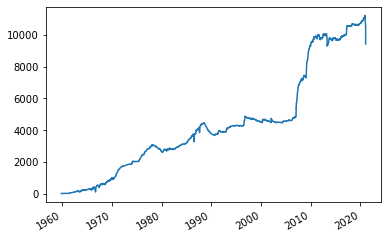

In [9]:
df.index.value_counts().plot()